<a href="https://colab.research.google.com/github/yubin8773/2021-deep-learning/blob/main/00_train_batchnormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiENDw8egRqMqsgQ1Cq3rKgHLHMILItWO3TtfOsBfPCCsVrln4WJAw


In [ ]:
import numpy as np
import tensorflow as tf
import cv2, os, glob, random
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug as ia

from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

## argument

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

ramdom_seed = 5198
tf.random.set_seed(ramdom_seed)
np.random.seed(ramdom_seed)
random.seed(ramdom_seed)
os.environ['PYTHONHASHSEED'] = str(ramdom_seed)
init_k = tf.keras.initializers.he_normal(seed=ramdom_seed)


## data loader

In [ ]:
raw_data = np.load('/content/drive/MyDrive/RF data/all_data_np_1005_no_z_1.npy')
data_input = np.reshape(raw_data, (-1,16,150))
data_label = np.load('/content/drive/MyDrive/RF data/posnum_np_1005_no_z_1.npy')

In [ ]:
data_input = np.reshape(raw_data, (-1, 16, 150))
print(data_input.shape)

(1089, 16, 150)


In [ ]:
idx = list(np.arange(len(raw_data)))
rand_idx = random.sample(idx, 200)
complement = list(set(idx) - set(rand_idx))
print(complement)

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 97, 98, 99, 100, 101, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 148, 149, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 170, 171, 172, 175, 177, 178, 179, 180, 181, 183, 184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 215, 217, 218, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 267, 268, 

In [ ]:
len(idx)

1089

In [ ]:
X_train = data_input[complement]
Y_train = data_label[complement]
x_val = data_input[rand_idx]
y_val = data_label[rand_idx]

In [ ]:
# def image_aug_batch(img):
#     seq = iaa.Sequential([
#     iaa.Multiply((0.9, 1.1)), 
#     iaa.Affine(
#         translate_px={"x": 10, "y": 10},
#         scale=(0.95, 1.05),
#         rotate=(-180, 180)),
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5)
#     ])
#     images_aug = seq(images = img.astype(np.float32)/255.)
#     return images_aug

In [ ]:
def data_generator(train_imgs, train_labels, batch_size, aug = True):
    idx = 0
    idx_list = list(range(0,len(train_imgs)))
    random.shuffle(idx_list)
    while 1:
        if idx > len(idx_list) - batch_size:
            tmp_list = idx_list[idx:]
            idx = 0
        else:
            tmp_list = idx_list[idx:idx + batch_size]
            idx = idx + batch_size
        batch_images = train_imgs[tmp_list]
        batch_labels = train_labels[tmp_list]
        
        # if aug == True:
        #     batch_images = image_aug_batch(batch_images)
        #     batch_images = (batch_images * 255).astype(np.uint8)
        #     batch_images = np.clip(batch_images, 0, 255)
        batch_images = batch_images
        yield batch_images, batch_labels

In [ ]:
batch_size = 256
train_gen = data_generator(X_train, Y_train, batch_size, aug = True)
val_gen = data_generator(x_val, y_val, batch_size, aug = False)
# test_gen = data_generator(X_test, y_test, batch_size, aug = False)

## model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

input_shape = (16,150,1)
input_ = Input(input_shape)
x = Conv2D(32, (1,32), padding='valid', activation = 'relu')(input_)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1,32), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1,32), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1,16), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (1,16), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (1,7), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (1,5), padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((1,3), strides = 1)(x)
x = BatchNormalization()(x)
x = Conv2D(1, (1,3), padding='valid', activation = 'relu')(x)

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(4)(x)
x = tf.keras.layers.ReLU(max_value = 10)(x)

model = tf.keras.models.Model(input_, x)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 150, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 119, 32)       1056      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 119, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 117, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 117, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 86, 64)        65600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 86, 64)        256   

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002),
              loss=tf.keras.losses.MSE, metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## save path

In [ ]:
file_save_name = 'saved_model/00_test'

try:
    if not os.path.exists(file_save_name):
        os.makedirs(file_save_name)
except OSError:
    print ('Error: Creating directory. ' +  file_save_name)

In [ ]:
filepath = f'{file_save_name}' + '/model-{epoch:04d}.h5'
checkpoint = ModelCheckpoint(filepath, save_weights_only=True)

## train

In [ ]:
model_hist = model.fit_generator(train_gen, epochs = 100, steps_per_epoch = int(len(data_input)/batch_size)+1, callbacks = [checkpoint], validation_data=val_gen, validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
5/5 [==============================] - 43s 2s/step - loss: 20.2973 - mae: 3.1857 - val_loss: 21.1733 - val_mae: 3.3337
Epoch 2/100
5/5 [==============================] - 2s 461ms/step - loss: 18.3480 - mae: 2.9850 - val_loss: 21.1459 - val_mae: 3.3312
Epoch 3/100
5/5 [==============================] - 2s 468ms/step - loss: 16.5951 - mae: 2.7934 - val_loss: 21.1172 - val_mae: 3.3287
Epoch 4/100
5/5 [==============================] - 2s 461ms/step - loss: 15.4928 - mae: 2.6804 - val_loss: 21.0889 - val_mae: 3.3262
Epoch 5/100
5/5 [==============================] - 2s 464ms/step - loss: 14.3260 - mae: 2.5631 - val_loss: 21.0620 - val_mae: 3.3238
Epoch 6/100
5/5 [==============================] - 2s 467ms/step - loss: 13.4824 - mae: 2.4767 - val_loss: 21.0376 - val_mae: 3.3217
Epoch 7/100
5/5 [==============================] - 2s 464ms/step - loss: 12.9646 - mae: 2.4129 - val_loss: 21.0037 - val_mae: 3.3189
Epoch 8/100
5/5 [==============================] - 2s 462ms/step - loss

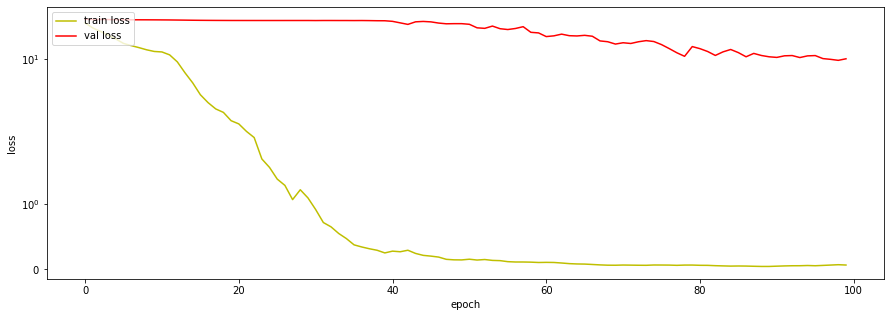

In [ ]:
fig, loss_ax = plt.subplots(figsize =(15,5))

loss_ax.plot(model_hist.history['loss'], 'y', label='train loss')
loss_ax.plot(model_hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
loss_ax.set_yscale('symlog')

plt.show()

In [ ]:
predi = model.predict(data_input)

In [ ]:
predi_round = np.round(predi,2)

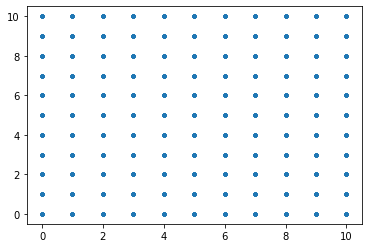

In [ ]:
plt.scatter(data_label[:,0], data_label[:,1], s=10)

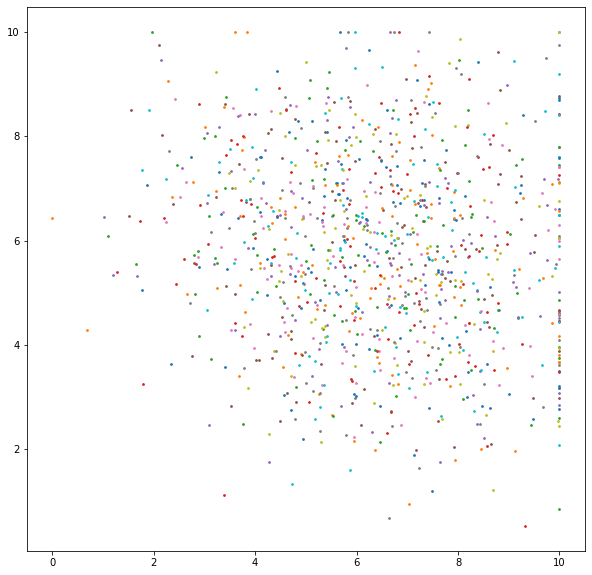

In [ ]:
plt.figure(figsize = (10,10))
for i in range(int(len(predi_round)/9)):
    plt.scatter(predi_round[i*9:i*9+9,0], predi_round[i*9:i*9+9,1], s = 3)

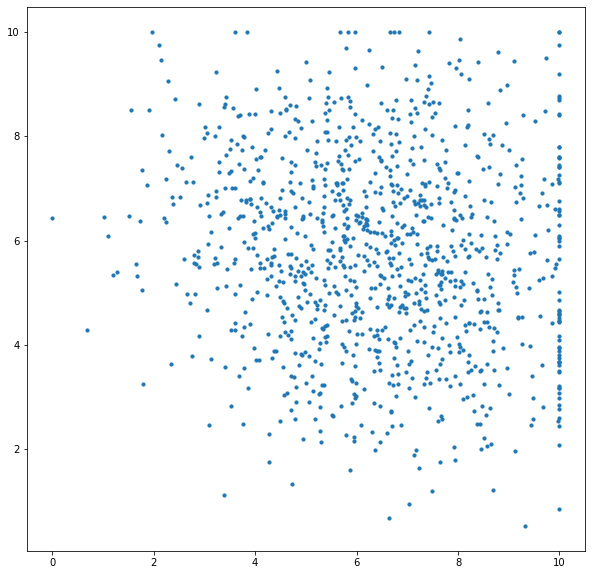

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(predi_round[:,0], predi_round[:,1], s=10)

In [ ]:
raw_data.shape

(2178, 2, 8, 150)

In [ ]:
raw_data_1.shape

(2178, 2, 8, 150)

In [ ]:
raw_data_2